In [ ]:
# !pip install mpl_finance
# !pip install yfinance

In [1]:
%matplotlib inline
from lstm import *
import numpy as np
import pandas as pd
import math
import sklearn
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
import os
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as mticker
from mpl_finance import candlestick_ohlc
import yfinance as yf

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt


from Constants import Consts

/home/eytan/miniconda/envs/data-science/lib/python3.7/site-packages/mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# from google.colab import drive
# drive.mount('/content/drive')

device(type='cpu')

## Adding gold and VIX (Volatility Index) to augment our stock data

In [3]:
prev_5_years = (datetime.today() - timedelta(days=1825)).strftime('%Y-%m-%d')
today = datetime.today().strftime('%Y-%m-%d')

gold_etf = yf.Ticker('GLD')
gold_etf_data = gold_etf.history(start=prev_5_years, end=today, auto_adjust=True, actions=False)
gold_etf_data['date_timestamp'] = dates.date2num(gold_etf_data.index)
gold_etf_data

,Open,High,Low,Close,Volume,date_timestamp
Date,,,,,,
2015-12-21,102.949997,103.519997,102.830002,103.150002,6378900,16790.0
2015-12-22,103.089996,103.199997,102.559998,102.610001,4123500,16791.0
2015-12-23,102.400002,102.589996,102.209999,102.309998,2821400,16792.0
2015-12-24,102.820000,103.050003,102.769997,103.050003,1710200,16793.0
2015-12-28,102.480003,102.599998,102.029999,102.269997,3356200,16797.0
...,...,...,...,...,...,...
2020-12-14,171.910004,172.520004,170.910004,171.539993,7644400,18610.0
2020-12-15,173.429993,173.979996,173.059998,173.940002,6848600,18611.0
2020-12-16,174.130005,175.020004,173.020004,174.899994,8174700,18612.0


In [4]:
vix_index = yf.Ticker('^VIX')
vix_data = vix_index.history(start=prev_5_years, end=today, auto_adjust=True, actions=False)
vix_data['date_timestamp'] = dates.date2num(vix_data.index)
vix_data

,Open,High,Low,Close,Volume,date_timestamp
Date,,,,,,
2015-12-21,19.639999,20.209999,18.700001,18.700001,0,16790.0
2015-12-22,17.610001,18.219999,16.600000,16.600000,0,16791.0
2015-12-23,15.860000,16.250000,15.330000,15.570000,0,16792.0
2015-12-24,15.440000,15.880000,14.450000,15.740000,0,16793.0
2015-12-28,17.650000,18.129999,16.879999,16.910000,0,16797.0
...,...,...,...,...,...,...
2020-12-14,22.670000,24.820000,21.950001,24.719999,0,18610.0
2020-12-15,24.000000,24.070000,22.730000,22.889999,0,18611.0
2020-12-16,22.510000,23.670000,22.290001,22.500000,0,18612.0


In [5]:
apple = yf.Ticker('AAPL')
apple_data = apple.history(start=prev_5_years, end=today, auto_adjust=True, actions=False)
apple_data['date_timestamp'] = dates.date2num(apple_data.index)

first_date = apple_data.iloc[0].name

apple_data

,Open,High,Low,Close,Volume,date_timestamp
Date,,,,,,
2015-12-21,24.847961,24.868808,24.451895,24.859543,190362400,16790.0
2015-12-22,24.875757,24.949874,24.655719,24.836382,131157600,16791.0
2015-12-23,24.845648,25.211605,24.829435,25.156017,130629600,16792.0
2015-12-24,25.246347,25.246347,25.003147,25.021677,54281600,16793.0
2015-12-28,24.919764,24.942927,24.593184,24.741419,106816800,16797.0
...,...,...,...,...,...,...
2020-12-14,122.599998,123.349998,121.540001,121.779999,79184500,18610.0
2020-12-15,124.339996,127.900002,124.129997,127.879997,157572300,18611.0
2020-12-16,127.410004,128.369995,126.559998,127.809998,98208600,18612.0


In [6]:
apple_data['gold_close'] = gold_etf_data.Close
apple_data['vix_close'] = vix_data.Close

In [7]:
apple_data

,Open,High,Low,Close,Volume,date_timestamp,gold_close,vix_close
Date,,,,,,,,
2015-12-21,24.847961,24.868808,24.451895,24.859543,190362400,16790.0,103.150002,18.700001
2015-12-22,24.875757,24.949874,24.655719,24.836382,131157600,16791.0,102.610001,16.600000
2015-12-23,24.845648,25.211605,24.829435,25.156017,130629600,16792.0,102.309998,15.570000
2015-12-24,25.246347,25.246347,25.003147,25.021677,54281600,16793.0,103.050003,15.740000
2015-12-28,24.919764,24.942927,24.593184,24.741419,106816800,16797.0,102.269997,16.910000
...,...,...,...,...,...,...,...,...
2020-12-14,122.599998,123.349998,121.540001,121.779999,79184500,18610.0,171.539993,24.719999
2020-12-15,124.339996,127.900002,124.129997,127.879997,157572300,18611.0,173.940002,22.889999
2020-12-16,127.410004,128.369995,126.559998,127.809998,98208600,18612.0,174.899994,22.500000


In [8]:
apple_close_delta = apple_data.Close.diff()[1:]
apple_close_delta

Date
2015-12-22   -0.023161
2015-12-23    0.319635
2015-12-24   -0.134340
2015-12-28   -0.280258
2015-12-29    0.444706
                ...   
2020-12-14   -0.630005
2020-12-15    6.099998
2020-12-16   -0.070000
2020-12-17    0.889999
2020-12-18   -2.039993
Name: Close, Length: 1258, dtype: float64

In [9]:
# Make the positive gains (up) and negative gains (down) Series
up, down = apple_close_delta.copy(), apple_close_delta.copy()
up[up < 0] = 0
down[down > 0] = 0

In [10]:
window_length = 14

# Calculate the EWMA
roll_up1 = up.ewm(span=window_length).mean()
roll_down1 = down.abs().ewm(span=window_length).mean()

# Calculate the RSI based on EWMA
RS1 = roll_up1 / roll_down1
RSI1 = 100.0 - (100.0 / (1.0 + RS1))
RSI1

Date
2015-12-22     0.000000
2015-12-23    94.091161
2015-12-24    64.609846
2015-12-28    36.831100
2015-12-29    64.654515
                ...    
2020-12-14    52.546888
2020-12-15    72.762864
2020-12-16    72.354722
2020-12-17    74.456663
2020-12-18    61.991005
Name: Close, Length: 1258, dtype: float64

In [11]:
try:
    apple_data.drop(index=first_date, inplace=True)
except KeyError:
    pass

In [12]:
apple_data['RSI'] = RSI1
apple_data.head()

,Open,High,Low,Close,Volume,date_timestamp,gold_close,vix_close,RSI
Date,,,,,,,,,
2015-12-22,24.875757,24.949874,24.655719,24.836382,131157600,16791.0,102.610001,16.60,0.000000
2015-12-23,24.845648,25.211605,24.829435,25.156017,130629600,16792.0,102.309998,15.57,94.091161
2015-12-24,25.246347,25.246347,25.003147,25.021677,54281600,16793.0,103.050003,15.74,64.609846
2015-12-28,24.919764,24.942927,24.593184,24.741419,106816800,16797.0,102.269997,16.91,36.831100
2015-12-29,24.773845,25.345942,24.750684,25.186125,123724800,16798.0,102.199997,16.08,64.654515


In [13]:
# Create a list of lists where each inner-list represents
# one day's trading history
apple = apple_data[[Consts.DATE_TIMESTAMP, Consts.OPEN, Consts.HIGH, 
                    Consts.LOW, Consts.CLOSE, Consts.VOLUME, 'gold_close', 'vix_close', 'RSI']]
apple_list = apple.values.tolist()

# Plot a candlestick chart for Apples stock

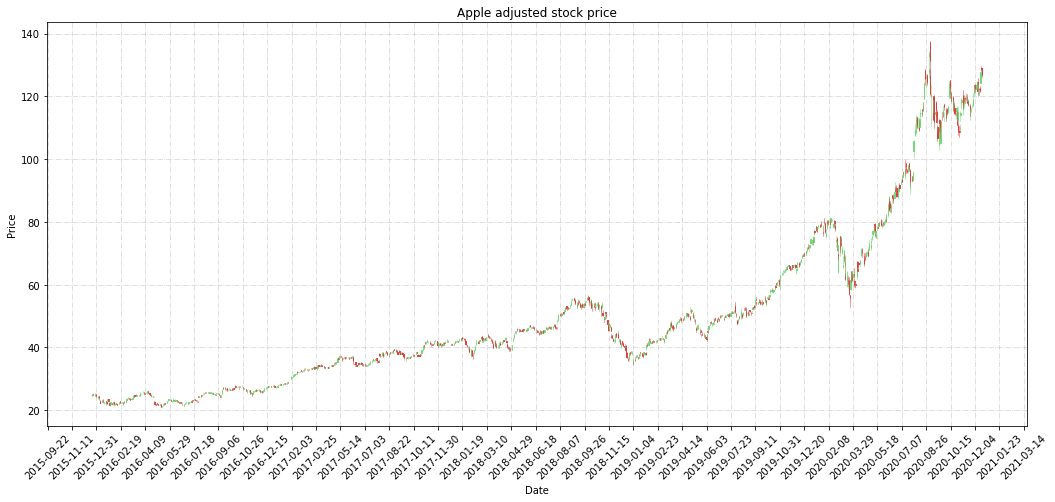

In [14]:

# Build the plot
fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot2grid((1,1), (0,0))

candlestick_ohlc(ax1, apple_list, width=0.4, colorup='#77d879', colordown='#db3f3f',)

for label in ax1.xaxis.get_ticklabels():
     label.set_rotation(45)

ax1.xaxis.set_major_formatter(dates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mticker.MaxNLocator(50))
ax1.grid(True, alpha=0.5, linestyle='-.')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Apple adjusted stock price')
plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)
plt.show()

# Scaling the data

In [15]:
desired_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'gold_close', 'vix_close', 'RSI']
close_idx = desired_columns.index('Close')
apple = apple[desired_columns]
apple

,Open,High,Low,Close,Volume,gold_close,vix_close,RSI
Date,,,,,,,,
2015-12-22,24.875757,24.949874,24.655719,24.836382,131157600,102.610001,16.600000,0.000000
2015-12-23,24.845648,25.211605,24.829435,25.156017,130629600,102.309998,15.570000,94.091161
2015-12-24,25.246347,25.246347,25.003147,25.021677,54281600,103.050003,15.740000,64.609846
2015-12-28,24.919764,24.942927,24.593184,24.741419,106816800,102.269997,16.910000,36.831100
2015-12-29,24.773845,25.345942,24.750684,25.186125,123724800,102.199997,16.080000,64.654515
...,...,...,...,...,...,...,...,...
2020-12-14,122.599998,123.349998,121.540001,121.779999,79184500,171.539993,24.719999,52.546888
2020-12-15,124.339996,127.900002,124.129997,127.879997,157572300,173.940002,22.889999,72.762864
2020-12-16,127.410004,128.369995,126.559998,127.809998,98208600,174.899994,22.500000,72.354722


#### Split the data into training and testing sets

In [16]:
test_size = 365
data = apple.values

train_data = data[:-test_size]
test_data = data[-test_size:]

In [17]:
scaler = StandardScaler()

train_data = scaler.fit_transform(train_data)
train_data = torch.FloatTensor(train_data).to(device)

len(train_data), train_data[:3]

(893,
 tensor([[-1.2405, -1.2531, -1.2449, -1.2470,  0.0134, -3.1909,  0.4421, -3.0401],
         [-1.2436, -1.2260, -1.2266, -1.2136,  0.0045, -3.2453,  0.2016,  2.0108],
         [-1.2018, -1.2225, -1.2082, -1.2277, -1.2913, -3.1113,  0.2413,  0.4282]]))

In [18]:
test_data = scaler.transform(test_data)
test_data = torch.FloatTensor(test_data).to(device)

len(test_data), test_data[:3]

(365,
 tensor([[ 1.3661,  1.3577,  1.4063,  1.3857, -1.0181,  2.4085, -0.5407,  0.2332],
         [ 1.4082,  1.4053,  1.4531,  1.4348, -1.0621,  2.4085, -0.4730,  0.5229],
         [ 1.4211,  1.4114,  1.4401,  1.4165, -1.0675,  2.2039, -0.4310,  0.3234]]))

# Creating our data for training

In [19]:
# we split the data into 100 day sequences
seq_len = 100
train_seq = create_sequences(train_data, seq_len, close_idx)
print(f'There are {len(train_seq)} training sequences where each sequence has a shape of {train_seq[0][0].shape}')
print(f'and each sequence is paired with the closing price of the next day.')

There are 793 training sequences where each sequence has a shape of torch.Size([100, 8])
and each sequence is paired with the closing price of the next day.


In [20]:
test_seq = create_sequences(test_data, seq_len, close_idx)
print(f'There are {len(test_seq)} testing sequences where each sequence has a shape of {test_seq[0][0].shape}')
print(f'and each sequence is paired with the closing price of the next day.')

There are 265 testing sequences where each sequence has a shape of torch.Size([100, 8])
and each sequence is paired with the closing price of the next day.


In [25]:
model = LSTM(8, 100, 1).to(device)
loss_function = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

LSTM(
  (lstm): LSTM(8, 100)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)


In [26]:
epochs = 10

loss_history = []
running_loss = []
for i in range(epochs):
    
    for j, (seq, label) in enumerate(train_seq):
        seq = seq.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()

        model.h0 = torch.zeros(1, 1, model.hidden_size, device=device)
        model.c0 = torch.zeros(1, 1, model.hidden_size, device=device)

        y_pred = model(seq)

        loss = loss_function(y_pred, label)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())

        if j % 50 == 0:
            avg_loss = sum(running_loss) / 50
            print(f'Epoch {i+1:3}, iteration {j:5}, loss: {avg_loss}')
            loss_history.append(avg_loss)
            running_loss = []

Epoch   1, iteration     0, loss: 0.05365501403808594
Epoch   1, iteration    50, loss: 0.35741174883311033
Epoch   1, iteration   100, loss: 0.04125142648514157
Epoch   1, iteration   150, loss: 0.0041621136624598876
Epoch   1, iteration   200, loss: 0.006669141723450594
Epoch   1, iteration   250, loss: 0.0051058656327899144
Epoch   1, iteration   300, loss: 0.0039597832928120625
Epoch   1, iteration   350, loss: 0.011478858912660143
Epoch   1, iteration   400, loss: 0.01639243549821913
Epoch   1, iteration   450, loss: 0.04183136518287938
Epoch   1, iteration   500, loss: 0.03714869876754165
Epoch   1, iteration   550, loss: 0.005427349638084706
Epoch   1, iteration   600, loss: 0.012269606584814028
Epoch   1, iteration   650, loss: 0.023068521191823947
Epoch   1, iteration   700, loss: 0.022868553977095873
Epoch   1, iteration   750, loss: 0.015343028327333742
Epoch   2, iteration     0, loss: 0.02562176803845432
Epoch   2, iteration    50, loss: 0.03891456511358229
Epoch   2, iter

Text(0, 0.5, 'loss')

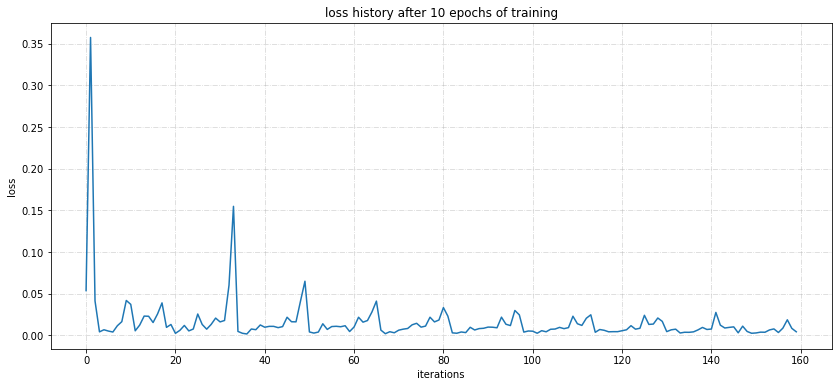

In [27]:
fig, ax1 = plt.subplots(1, 1, figsize=(14,6))

plt.title(f'loss history after {epochs} epochs of training')
ax1.plot(loss_history)
ax1.grid(alpha=.5, linestyle='-.')
plt.xlabel('iterations')
plt.ylabel('loss')

In [28]:
real_labels = []
predicted_labels = []

with torch.no_grad():
    for i, (seq, label) in enumerate(test_seq):
        seq = seq.to(device)
        label = label.to(device)
        
        model.h0 = torch.zeros(1, 1, model.hidden_size, device=device) 
        model.c0 = torch.zeros(1, 1, model.hidden_size, device=device)

        real_labels.append(label)
        predicted_labels.append(model(seq))
    

In [29]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(real_labels, predicted_labels)

3.970535

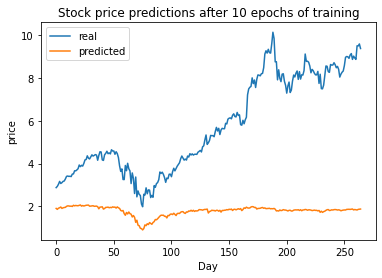

In [30]:

plt.title(f'Stock price predictions after {epochs} epochs of training')
plt.xlabel('Day')
plt.ylabel('price')
plt.plot(real_labels, label='real')
plt.plot(predicted_labels, label='predicted')
plt.legend();

# plt.savefig(f'/content/drive/My Drive/Deep Learning Final Project/{epochs}-epoch-preds1.jpg')